# EDA/Insights/Analytics Questions

The dataset is from Kaggle [Retail Transaction Dataset](https://www.kaggle.com/datasets/fahadrehman07/retail-transaction-dataset)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
raw_data = pd.read_csv("data/Retail_Transaction_Dataset.csv")
raw_data.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484


In [3]:
df = raw_data.copy()

df.dtypes

CustomerID              int64
ProductID              object
Quantity                int64
Price                 float64
TransactionDate        object
PaymentMethod          object
StoreLocation          object
ProductCategory        object
DiscountApplied(%)    float64
TotalAmount           float64
dtype: object

In [4]:
# Convert TransactionDate to datetime items

convert_dt = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M")
df["trans_time"] = df["TransactionDate"].apply(convert_dt)
df["trans_date"] = df["trans_time"].apply(lambda x: x.date())


# Promo penetration
df["promo_pen"] = df["DiscountApplied(%)"]/( df["DiscountApplied(%)"] + df["TotalAmount"])

In [5]:
df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount,trans_time,trans_date,promo_pen
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764,2023-12-26 12:32:00,2023-12-26,0.039358
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546,2023-08-05 00:00:00,2023-08-05,0.051835
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651,2024-03-11 18:51:00,2024-03-11,0.069941
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769,2023-10-27 22:00:00,2023-10-27,0.014286
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484,2023-12-22 11:38:00,2023-12-22,0.006396


# 1. Exploratory DataSet

## 1.1 Revenue




In [6]:
import matplotlib.pyplot as plt

<Axes: xlabel='trans_month'>

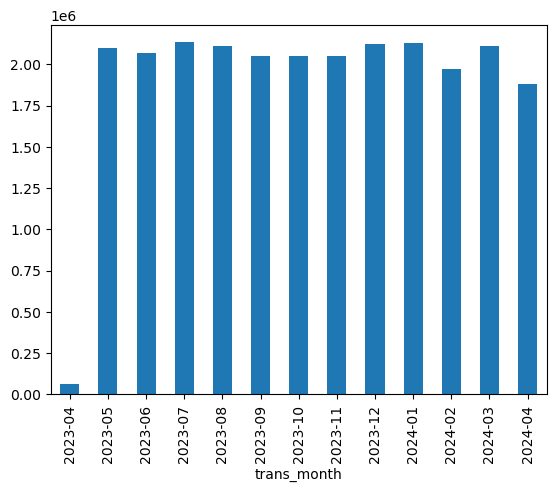

In [7]:
# Revenue by month
df["trans_month"] = df["trans_time"].apply(lambda x: x.strftime("%Y-%m"))
df_by_month = df[["TotalAmount", "trans_month"]].groupby("trans_month").sum()

df_by_month.plot(kind="bar", legend=False)


Wieldly steady monthly transactions. No seasonality. No trend. No growth.

<Axes: xlabel='ProductCategory'>

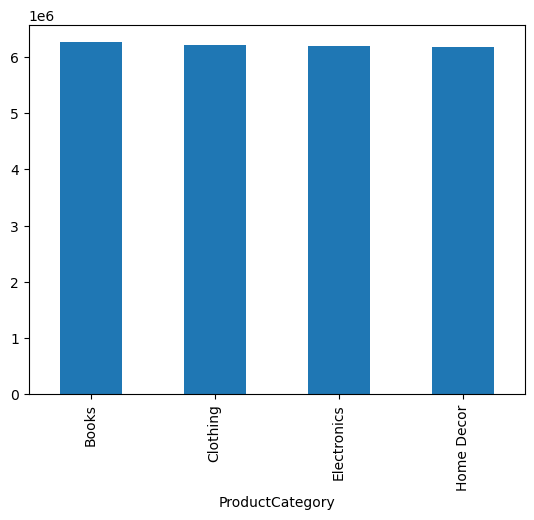

In [8]:
# Revenue by category
df_by_cat = df[["TotalAmount", "ProductCategory"]].groupby("ProductCategory").sum()

df_by_cat.plot(kind="bar", legend=False)


## 1.2 Customer

<Axes: xlabel='trans_month'>

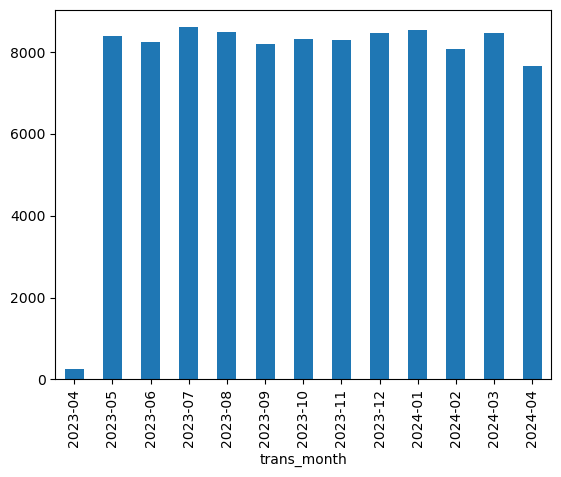

In [9]:
# 1.2.1 Customer_cnt by month

monthly_cnt = df[["trans_month", "CustomerID"]].groupby("trans_month").size()

monthly_cnt.plot(kind="bar", legend=False)

<Axes: xlabel='trans_month'>

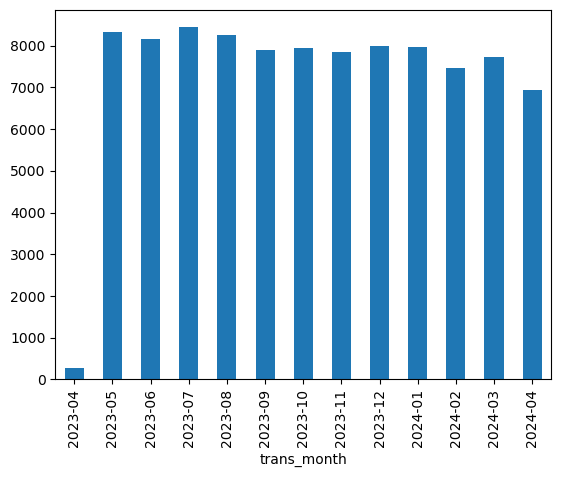

In [10]:
# 1.2.2 New customer count

first_time_purchase = df[["CustomerID", "trans_month"]].groupby(["CustomerID"]).min()
new_customer_aquisition = first_time_purchase.groupby(["trans_month"]).size()
new_customer_aquisition.plot(kind="bar", legend=False)

**Insight 1**: The count of new customers are declining.

In [11]:
# 1.2.3 Customer Rentention: How many customers come back 30 days after the first purchase?


install_dates  = df[["CustomerID", "trans_date"]].groupby(["CustomerID"]).min().reset_index().rename(columns={"trans_date": "first_trans_date"})

In [12]:
install_dates["after_30_days"] = install_dates["first_trans_date"].apply(lambda x: x + timedelta(days=30))

In [13]:
next_day_activity = pd.merge(
    install_dates, df, on="CustomerID"
)

In [14]:
next_day_activity = next_day_activity[(next_day_activity["first_trans_date"] < next_day_activity["trans_date"]) 
                  & 
                  (next_day_activity["after_30_days"] >= next_day_activity["trans_date"])
                 ]

In [15]:
return_customers = next_day_activity[["CustomerID", "first_trans_date"]].groupby(["first_trans_date"]).size().reset_index()
return_customers.columns = ["first_trans_date", "return_cnt"]

In [16]:
install_dates_agg = install_dates.groupby(["first_trans_date"]).size().reset_index()
install_dates_agg.columns = ["first_trans_date", "cnt"]

In [29]:
daily_retention = pd.merge(install_dates_agg, return_customers, on="first_trans_date", how="left")
daily_retention["return_cnt"] = daily_retention["return_cnt"].fillna(0)
daily_retention["retention"] = daily_retention["return_cnt"]/daily_retention["cnt"]
daily_retention["retention"] = daily_retention["retention"].apply(lambda x: round(x, 4))


<Axes: >

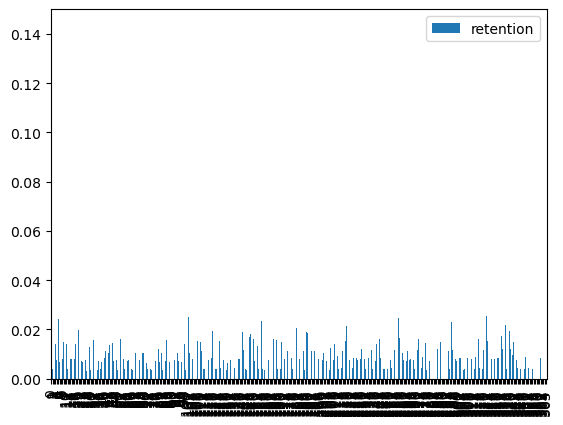

In [30]:
daily_retention[["first_trans_date", "retention"]].plot(kind="bar")

In [18]:
def add_label(df):
    if df["retention"] == 0:
        return "no-one-return"
    elif df["retention"] < 0.01:
        return "not-bad"
    elif df["retention"] < 0.02:
        return "doing-ok"
    else:
        return "awesome"
    
daily_retention["retention_label"] = daily_retention.apply(add_label, axis=1)

In [19]:
daily_retention.sort_values(by=["first_trans_date", "cnt"], ascending=[True, False])

,first_trans_date,cnt,return_cnt,retention,retention_label
0,2023-04-29,14,2.0,0.1429,awesome
1,2023-04-30,250,1.0,0.0040,not-bad
2,2023-05-01,262,3.0,0.0115,doing-ok
3,2023-05-02,285,4.0,0.0140,doing-ok
4,2023-05-03,268,2.0,0.0075,not-bad
...,...,...,...,...,...
361,2024-04-24,237,2.0,0.0084,not-bad
362,2024-04-25,228,0.0,0.0000,no-one-return
363,2024-04-26,274,0.0,0.0000,no-one-return
364,2024-04-27,248,0.0,0.0000,no-one-return


## 2. Product Recommendations

In [ ]:
# Find product pa

## 3. Channels